In [1]:
import quik_ai as qa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib.metadata import version 
print('Quik-AI Version: %s' % version('quik_ai'))

Quik-AI Version: 1.0.0


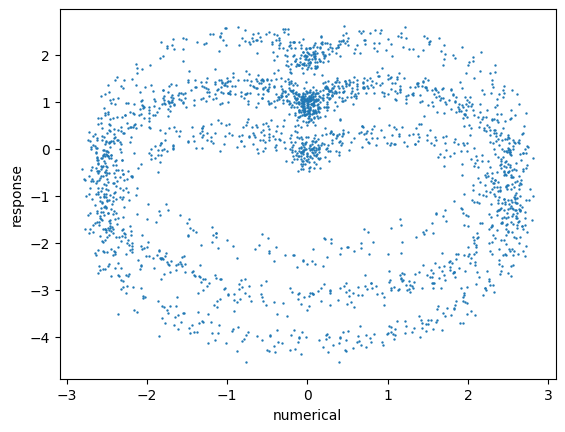

In [2]:
# build modified cardiac data: https://www.tensorflow.org/probability/api_docs/python/tfp/layers/MixtureNormal
n = 2400
time = np.random.uniform(low=-np.pi, high=np.pi, size=n)
radius = 2 * (1 - np.cos(time))

# build model predictors
hour = np.random.uniform(low=0, high=24, size=n)
x = radius * np.sin(time) + np.random.normal(loc=0., scale=0.1, size=n)
noise = np.random.normal(loc=0., scale=10, size=n)
categorical = np.random.choice(['A','B','C'], size=n, p=[0.2, 0.5, 0.3])

# build response
offset = (categorical == 'A').astype(float) - (categorical == 'C').astype(float)
y = radius * np.cos(time) + np.random.normal(loc=0., scale=0.1, size=n) + np.cos(hour / 24.0) + offset

# store in a dataframe
data = pd.DataFrame({
    'numerical' : x,
    'categorical' : categorical,
    'periodic' : hour,
    'noise' : noise,
    'response' : y,
})

# the joint distribution conditional on only x is a mess!
plt.scatter(data.numerical, data.response, s=0.5);
plt.xlabel('numerical');
plt.ylabel('response');

In [3]:
# split the data
training_data, validation_data, test_data = qa.train_val_test_split(data)

# create the driver, this will generate the tensorflow dataset and feed data
# also set the Noam optimizer
driver = qa.Driver(training_data, validation_data, test_data, qa.optimizers.Noam())

# what does our response look like?
head = qa.heads.GaussianMixture()

# all the predictors for the model
predictors = [
    qa.predictors.NumericalPredictor('numerical'),
    qa.predictors.CategoricalPredictor('categorical'),
    qa.predictors.PeriodicPredictor('periodic', 24.0),
    qa.predictors.NumericalPredictor('noise', drop=qa.tuning.HyperBoolean()),
]

# what is our model architecture? This will store
# our model, driver, and any other information we use in training
# testing, saving, and loading needed for this problem
model = qa.models.ResNet('response', head, predictors, driver)

# train the model, we can provide a hyperparameter tuner and other
# training parameters, by default we will use a custom BOHB tuner
model.train(qa.tuners.TunerContainer(qa.tuners.BOHB, max_epochs=1), full_rounds=1)

Trial 1 Complete [00h 00m 06s]
val_log_prob: 2.4209752082824707

Best val_log_prob So Far: 2.4209752082824707
Total elapsed time: 00h 00m 06s
INFO:tensorflow:Oracle triggered exit
Round 1 best score: 0.5490


In [4]:
# evaluate the model on test data
model.evaluate()

4/4 [==============================] - 2s 494ms/step - loss: 0.6635 - log_prob: 0.6436


{'loss': 0.6634718179702759, 'log_prob': 0.6436054110527039}

In [9]:
# save the model to disk and reload the model
# then test on the test data once again
model.save()
model = qa.HyperModel.load()

# evaluate again, this should be the same score as before
model.evaluate()

INFO:tensorflow:Assets written to: ./model\tf_model\assets


INFO:tensorflow:Assets written to: ./model\tf_model\assets


4/4 [==============================] - 1s 32ms/step - loss: 0.6635 - log_prob: 0.6436


{'loss': 0.6634718179702759, 'log_prob': 0.6436054110527039}

In [10]:
predictions = model.predict(test_data)

5/5 [==============================] - 1s 22ms/step


In [11]:
tdf = model.driver.get_tensorflow_dataset(
            test_data, 
            input_names=model.get_input_names(), 
            response=None, 
            run_forever=False, 
            time_window=model.time_window, 
            hp=None, 
            shuffle=False
        )

def predict_distribution(ds):
    res = []
    for x in ds:
        res.append(model.instance(x))
    return res

predict_distribution(tdf)

[<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[64] event_shape=[1] dtype=float32>,
 <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[64] event_shape=[1] dtype=float32>,
 <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[64] event_shape=[1] dtype=float32>,
 <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[48] event_shape=[1] dtype=float32>]

In [12]:
len(test_data)

240